In [1]:
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
out_path = './../../../fredrik/deep-botany/ensemble-2/run_0'

dsp = xr.open_dataset(out_path+'/profiles.001.nc')
ds = xr.open_mfdataset(out_path+'/*/samptend.x*y*.001.nc',
                              data_vars='minimal'
#                               coords="minimal",
#                               compat="override",
#                               join='inner'
                             )
ds

<xarray.Dataset> Size: 122MB
Dimensions:          (xt: 6, yt: 8, zt: 200, zm: 200, time: 96, xm: 6, ym: 8)
Coordinates:
  * xt               (xt) float32 24B 3.2e+03 9.6e+03 ... 2.88e+04 3.52e+04
  * yt               (yt) float32 32B 2.4e+03 7.2e+03 ... 3.12e+04 3.6e+04
  * zt               (zt) float32 800B 20.0 60.0 100.0 ... 2.699e+04 2.749e+04
  * zm               (zm) float32 800B 0.0 40.0 80.0 ... 2.674e+04 2.724e+04
  * time             (time) datetime64[ns] 768B 2024-08-01T00:30:00 ... 2024-...
  * xm               (xm) float32 24B 0.0 6.4e+03 1.28e+04 ... 2.56e+04 3.2e+04
  * ym               (ym) float32 32B 0.0 4.8e+03 9.6e+03 ... 2.88e+04 3.36e+04
Data variables: (12/33)
    thltendhadvall   (time, zt, yt, xt) float32 4MB dask.array<chunksize=(96, 200, 8, 6), meta=np.ndarray>
    thltendvadvall   (time, zt, yt, xt) float32 4MB dask.array<chunksize=(96, 200, 8, 6), meta=np.ndarray>
    thltenddifall    (time, zt, yt, xt) float32 4MB dask.array<chunksize=(96, 200, 8, 6), meta=np.ndarray>
    thltendradall    (time, zt, yt, xt) float32 4MB dask.array<chunksize=(96, 200, 8, 6), meta=np.ndarray>
    thltendmicroall  (time, zt, yt, xt) float32 4MB dask.array<chunksize=(96, 200, 8, 6), meta=np.ndarray>
    thltendlsall     (time, zt, yt, xt) float32 4MB dask.array<chunksize=(96, 200, 8, 6), meta=np.ndarray>
    ...               ...
    uqtwall          (time, zt, yt, xm) float32 4MB dask.array<chunksize=(96, 200, 8, 1), meta=np.ndarray>
    vqtsall          (time, zt, ym, xt) float32 4MB dask.array<chunksize=(96, 200, 1, 6), meta=np.ndarray>
    wqtmall          (time, zm, yt, xt) float32 4MB dask.array<chunksize=(96, 200, 8, 6), meta=np.ndarray>
    wmall            (time, zm, yt, xt) float32 4MB dask.array<chunksize=(96, 200, 8, 6), meta=np.ndarray>
    uwall            (time, zt, yt, xm) float32 4MB dask.array<chunksize=(96, 200, 8, 1), meta=np.ndarray>
    vsall            (time, zt, ym, xt) float32 4MB dask.array<chunksize=(96, 200, 1, 6), meta=np.ndarray>
Attributes:
    title:    000/samptend.x000y000.001.nc
    history:  Created on 20250301 at 041052.065
    Source:   DALES 4.4.2 git: v4.4.1-779-g5d0bcc
    Author:

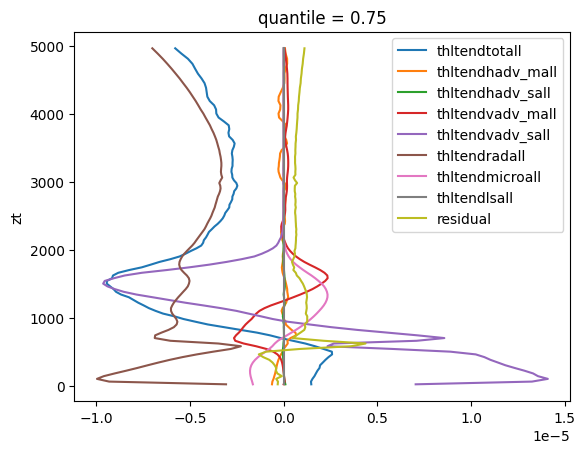

In [12]:
varplt = 'thl'
samp = 'all'
sortvar = 'qt'
quant = 0.75

terms = [varplt+'tendtot'+samp,
#          varplt+'tendhadv'+samp,
         varplt+'tendhadv_m'+samp,
         varplt+'tendhadv_s'+samp,
#          varplt+'tendvadv'+samp, # <- Replaced by vertically resolved fluxes
#          varplt+'tenddif'+samp,
         varplt+'tendvadv_m'+samp,
         varplt+'tendvadv_s'+samp,
         varplt+'tendrad'+samp,
         varplt+'tendmicro'+samp,
         varplt+'tendls'+samp,
#          varplt+'tendtop'+samp,
#          varplt+'tendaddon'+samp,
        ]

## Vertical advection decomposition
# - Does not close, and it is not entirely clear why. Probably inaccuracies in computing flux divergence?
rhobf = dsp['rhobf'].mean('time')
rhobh = dsp['rhobh'].mean('time')
def diff_vertical(var_to_diff):
    dz = var_to_diff['zm'].diff('zm')
    var_diffed = var_to_diff.diff('zm')/dz
    var_diffed = xr.concat([var_diffed, var_to_diff.isel(zm=-1)], dim="zm")
    var_diffed[-1] = 0. # Don't have the top boundary, so zero, but keep it to keep dimensions the same
    var_diffed = var_diffed.assign_coords(zm=ds['zt'].values).rename({'zm':'zt'})
    return var_diffed

# Meso-scale vertical flux
varpltmh = ds[varplt+'mall'].interp(zt=ds['zm']).drop_vars('zt')
varpltmh[0] = varpltmh[1] # Extrapolate first model level to surface
wmh = ds['wmall']
var_to_diff = rhobh*wmh*varpltmh
ds[varplt+'tendvadv_m'+samp] = -diff_vertical(var_to_diff)/rhobf

# Part of the vertical flux which is not balanced by a horizontal advection term that vanishes due to continuity:
wmf = ds['wmall'].interp(zm=ds['zt']).drop_vars('zm')
ds[varplt+'tendvadv_m'+samp] = -diff_vertical(varpltmh)*wmf

# Small-scale vertical flux
var_to_diff = ds['w'+varplt+'mall']*rhobh
ds[varplt+'tendvadv_s'+samp] = -diff_vertical(var_to_diff)/rhobf

# Horizontal advection decomposition
lx = ds['xm'].diff('xm')[0]
ly = ds['ym'].diff('ym')[0]

# Small scale fluxes - d/dx(us'*chis')m, primes are fluctuations over block edge average
ds[varplt+'tendhadv_s'+samp] =-(( ds['u'+varplt+'wall'].roll(xm=-1)/lx # Eastern edge
                                 -ds['u'+varplt+'wall']/lx             # Western edge
                                ).assign_coords(xm=ds['xt'].values).rename({'xm':'xt'})
                                +            
                                ( ds['v'+varplt+'sall'].roll(ym=-1)/ly # Northern edge
                                 -ds['v'+varplt+'sall']/ly             # Southern edge
                                ).assign_coords(ym=ds['yt'].values).rename({'ym':'yt'})
                               )

# Block-scale fluxes - d/dx(um*chim), m means block edge average
ds[varplt+'tendhadv_m'+samp] =-(( (ds['uwall']*ds[varplt+'wall']).roll(xm=-1)/lx # Eastern edge
                                 -(ds['uwall']*ds[varplt+'wall'])/lx             # Western edge
                                ).assign_coords(xm=ds['xt'].values).rename({'xm':'xt'})
                                +            
                                ( (ds['vsall']*ds[varplt+'sall']).roll(ym=-1)/ly # Northern edge
                                 -(ds['vsall']*ds[varplt+'sall'])/ly             # Southern edge
                                ).assign_coords(ym=ds['yt'].values).rename({'ym':'yt'})
                               )

# Part of block-scale horizontal fluxes that is balanced by chi*dw/dz: chim*d/dx(um)
# i.e. we remain with -um*d/dx(chim) = -d/dx(um*chim) + chim*d/dx(um)
hadv_bal = ds[varplt+'mall']*(((ds['uwall'].roll(xm=-1) - ds['uwall'])/lx
                              ).assign_coords(xm=ds['xt'].values).rename({'xm':'xt'})
                              +
                              ((ds['vsall'].roll(ym=-1) - ds['vsall'])/ly
                              ).assign_coords(ym=ds['yt'].values).rename({'ym':'yt'})
                             )
ds[varplt+'tendhadv_m'+samp] = ds[varplt+'tendhadv_m'+samp] + hadv_bal

# Part of horizontal advection due to advection with mean ul: ul*d/dx(chim)
# i.e. we remain with um*d/dx(chim) (and we need to subtract this from both sides, so from tendency too)
ul = dsp['u']
hadv_ls = ul * (((ds[varplt+'wall'].roll(xm=-1) - ds[varplt+'wall'])/lx
                ).assign_coords(xm=ds['xt'].values).rename({'xm':'xt'})
                +
                ((ds[varplt+'sall'].roll(ym=-1) - ds[varplt+'sall'])/ly
                ).assign_coords(ym=ds['yt'].values).rename({'ym':'yt'})
               )
ds[varplt+'tendhadv_m'+samp] = ds[varplt+'tendhadv_m'+samp] + hadv_ls
ds[varplt+'tendtot'+samp] = ds[varplt+'tendtot'+samp] + hadv_ls

sort = ds[sortvar+'m'+samp].integrate(coord='zt')
resid = ds[terms[0]] # Make tendency the first term
for i in range(len(terms)):
# for i in range(1):
#     if i == 2:
#         termi = (ds[terms[i]]+ds[varplt+'tenddif'+samp])
#     else:
    termi = ds[terms[i]]
    termi = termi.where(sort>sort.quantile(quant, dim=('xt','yt'))).mean(['time','xt','yt'])
    termi.sel(zt=slice(0,5000)).plot(y='zt', label=terms[i])
    if i == 0:
        resid = termi
    else:
        resid = resid - termi
resid.sel(zt=slice(0,5000)).plot(y='zt',label='residual')
plt.legend()